# Demo 2: Predicting latent dynamics from LIGS time series

This notebook is a short demonstration of the LIGSNet autoencoder for the prediction of LIGS harmonic constants.\
The learning problem, in this scenario, can be be framed as a 1D manifold learning problem. The latent variable is one-dimensional according to prior exploratory analysis via "tulip", and can be interpreted from an ordinal ranking point of view.\
The model consists of a convolutional autoencoder with a single hidden unit in the bottleneck. The network was trained to reconstruct its input, which consists of a LIGS data set acquired in a high-pressure hydrogen-air gas turbine engine [(Chaib et al. 2024)](https://doi.org/10.1115/1.4065996) at the Gas Turbine Research Center (Cardiff, Wales, UK).\
More details are provided in the associated paper(s).

## Loading packages

### Loading base packages

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
from sklearn.metrics import classification_report
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

if "CHDIR_EXECUTED" not in globals():
    os.chdir("..")
    CHDIR_EXECUTED = True

print("Current directory: " + os.getcwd())

Current directory: /Users/oussamachaib/Documents/GitHub/LIGSNet


### Loading custom packages

In [2]:
from loaders import load_preprocessed
from models.ConvAutoencoder import ConvAutoencoder

## Visualizing data

### Loading preprocessed LIGS data set

The preprocessed data set consists of:
* X : $n\times p$ matrix where rows correspond to individual observations (signals) and columns are features (voltage measurements per unit time)

In [3]:
X, _ =  load_preprocessed()

### Plotting a subset of the LIGS data set

As can be seen from the plot down below, our data consists of a mixture of different signatures of different frequencies, decay times, and magnitudes. In addition, some samples appear to be noisier than others. It is hard to make sense of the data given these large variations..

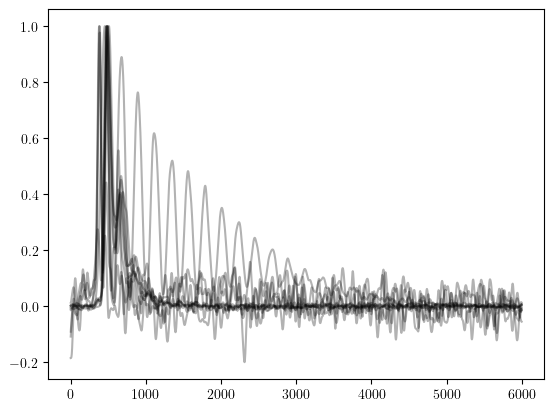

In [144]:
plt.figure()
[plt.plot(X[n,:], c = 'k', alpha = .3) for _, n in enumerate(np.linspace(0, 25000-1, 10, dtype = int))]
plt.show()

## Loading pretrained CNN

Some clarifications:
1. The autoencoder is located in the "models" folder. It is sufficient to call the ConvAutoencoder class once to load the model.
2. Calling the "load_pretrained()" method will load the pretrained autoencoder. The latter was trained on the preprocessed data set.

In [5]:
model = ConvAutoencoder()
model = model.load_pretrained()
model.to('cpu');

We can visualize the architecture of the network. The autoencoder consists of a mirrored encoder-decoder network with a convolutional backbone followed by a set of dense layers. The bottleneck has a single hidden unit, given prior analysis has shown the manifold is one-dimensional.\

In [6]:
model

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 12, kernel_size=(19,), stride=(3,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(12, 12, kernel_size=(19,), stride=(2,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv1d(12, 24, kernel_size=(7,), stride=(2,))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(24, 24, kernel_size=(5,), stride=(2,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv1d(24, 48, kernel_size=(5,), stride=(2,))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv1d(48, 48, kernel_size=(5,), stride=(2,))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv1d(48, 48, kernel_size=(3,), stride=(2,))
    (13): LeakyReLU(negative_slope=0.01)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=1344, out_features=100, bias=True)
    (16): LeakyReLU(negative_slope=0.01)
    (17): Linear(in_features=100, out_features=50, bias=True)
    (18): LeakyReLU(negative_slope=0.01)
    (19): Linear(in_features=50, out_

## Visualizing the manifold

We can now proceed with the model. A simple forward prop in the encoder will output the content of the bottleneck, which corresponds to the latent variable.

Similar to before, some conversions should be made:
1. The data set has to be converted to a torch.float32 tensor.
2. The data set should be in the shape ($n$,1,$p$) where $n$ and $p$ refer to the number of observations (signals) and the number of features ($6000$ voltage measurements per unit time, by definition). The second dimension is the number of channels which is always going to be unity in the present setting.

We will run the model on the full data set.

In [7]:
S = X.astype(np.float32)

with torch.no_grad():
    pred = model.encoder(torch.from_numpy(S).unsqueeze(1))

z = np.array(pred.numpy()).flatten()

We can visualize the manifold via PCA.

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=3)
embeddings = pca.fit_transform(X)

The content of the embeddings matrix represents the projection of the LIGS data set in a latent orthogonal 3D dimensional space represented by the eigenvectors of the covariance matrix of the data (i.e., the three first principal components)

In [21]:
embeddings.shape

(25000, 3)

In [142]:
# Some plotting settings
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


fnt = 20
elev = 25

def plot1(azim, elev):
    fig = plt.figure(figsize = (4,3), dpi = 300)
    
    ax = fig.add_subplot(111, projection = '3d')
    sm = ax.scatter(embeddings[::5,0], embeddings[::5,1], embeddings[::5,2], s = 60,
                    c = 'gray', edgecolors='k', alpha = .1, linewidths=.2)
    
    ax.grid(False)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_zticks(())
    ax.azim = azim
    ax.elev = elev
    ax.set_proj_type('persp', focal_length=.2)
    ax.tick_params(labelsize = 10, direction = 'in')
    
    ax.set_xlabel(f'$\eta_1$', fontsize = fnt, labelpad = -15)
    ax.set_ylabel(f'$\eta_2$', fontsize = fnt, labelpad = -15)
    ax.set_zlabel(f'$\eta_3$', fontsize = fnt, labelpad = -15)
    
    fig.subplots_adjust(left = .1, right = .8)
    plt.show()

def plot2(azim, elev):
    cMap = plt.get_cmap('RdBu_r')
    fig = plt.figure(figsize = (4,3), dpi = 300)
    
    ax = fig.add_subplot(111, projection = '3d')
    sm = ax.scatter(embeddings[::5,0], embeddings[::5,1], embeddings[::5,2], s = 60, c = cMap(((z[::5]+15)/20)),
                    edgecolors='k', alpha = .1, linewidths=.2)
    
    ax.grid(False)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_zticks(())
    ax.azim = azim
    ax.elev = elev
    ax.set_proj_type('persp', focal_length=.2)
    ax.tick_params(labelsize = 10, direction = 'in')
    
    ax.set_xlabel(f'$\eta_1$', fontsize = fnt, labelpad = -15)
    ax.set_ylabel(f'$\eta_2$', fontsize = fnt, labelpad = -15)
    ax.set_zlabel(f'$\eta_3$', fontsize = fnt, labelpad = -15)
    
    norm = plt.Normalize(vmin=0, vmax = 1)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cMap), ax = ax, shrink = .4, ticks = [0,1],
                      location = 'top', orientation = 'horizontal', aspect = 30, pad = -0.05,
                      ticklocation = 'bottom')
    cb.set_label(label='$z_*$', size=20, labelpad = 0)
    cb.ax.tick_params(labelsize=13, pad = 0)
    cb.set_ticklabels(['initial','terminal'])
    cb.set_alpha(1)
    
    fig.subplots_adjust(left = .1, right = .8)
    plt.show()

The orthogonal projection yields the characteristic looping manifold as can be seen down below. The images represent the same projection but viewed from three different viewpoints.\
The manifold is quite complex and highly nonlinear as can be seen from the image. However, it does have some structure to it!\
**The challenge is to be able to reduce such a complex manifold to a single latent variable to map its dynamics.**

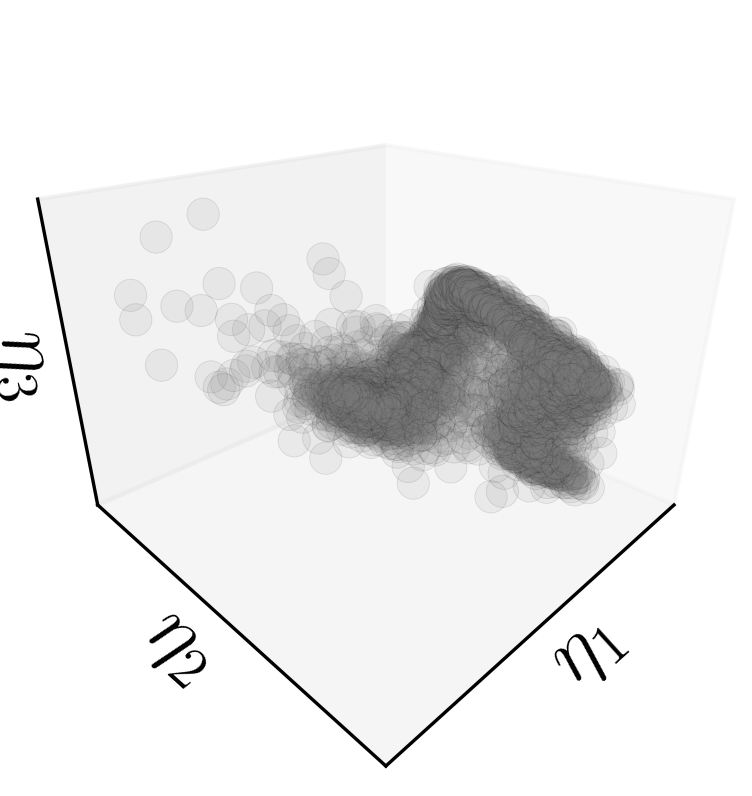

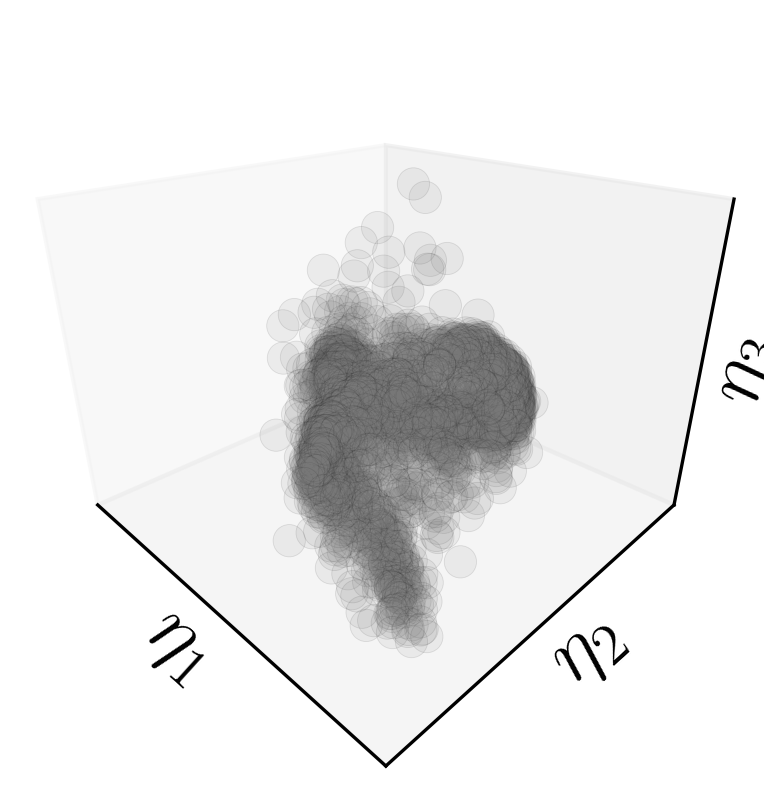

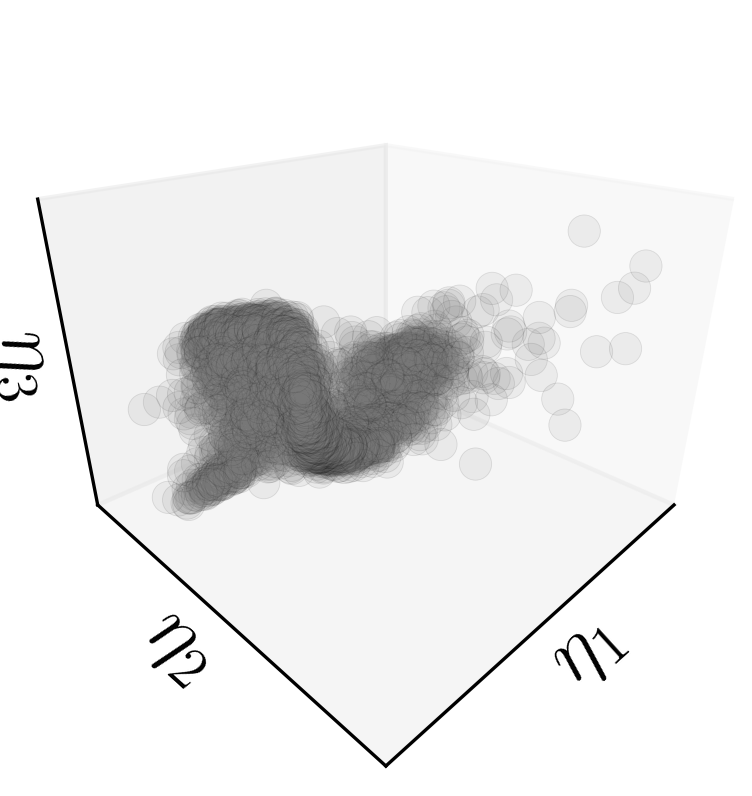

In [139]:
for _, a in enumerate([45, 45+90, 45+2*90]):
    plot1(a, elev)

## Visualizing the latent variable

We assume the manifold is indeed one-dimensional, and can be approximated by a curved line that traverses the densest region in this cloud of points.\
**That is precisely what the autoencoder was able to learn!**\
Notice how the lowest and highest values of the latent variable $z_*$ sit at the initial and terminal states of the manifold (i.e., start and end) while all points in-between appear to sit at an intermediate stage, as expected!

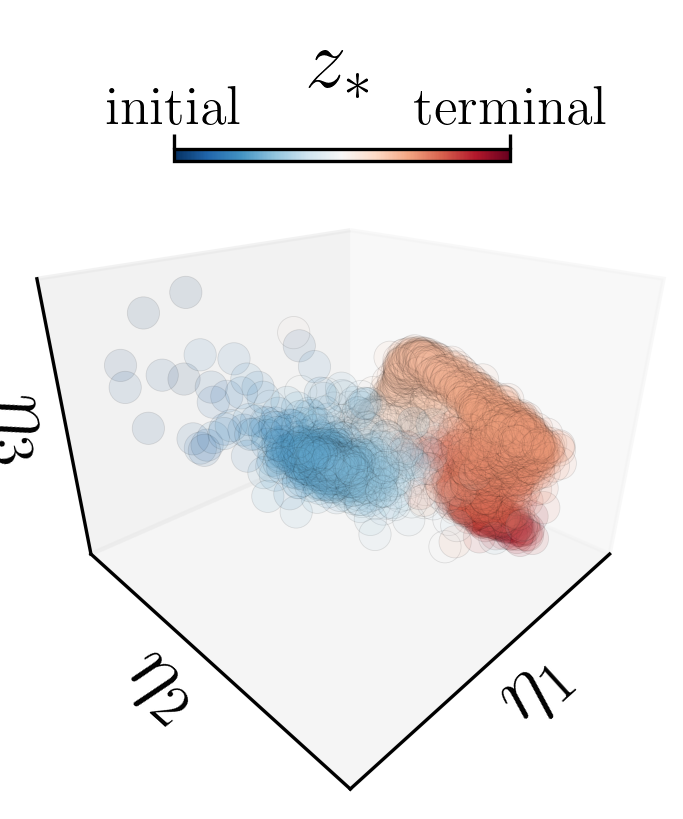

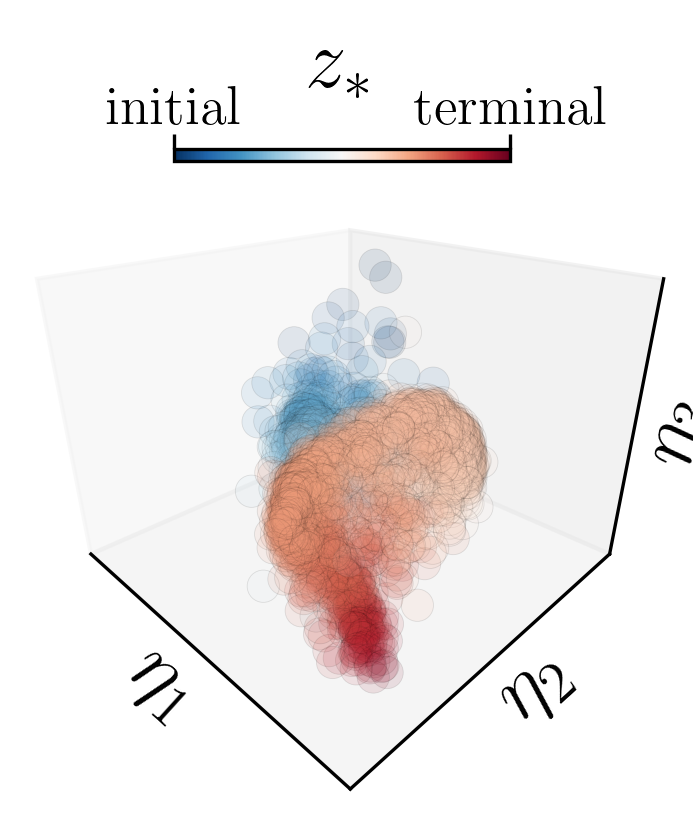

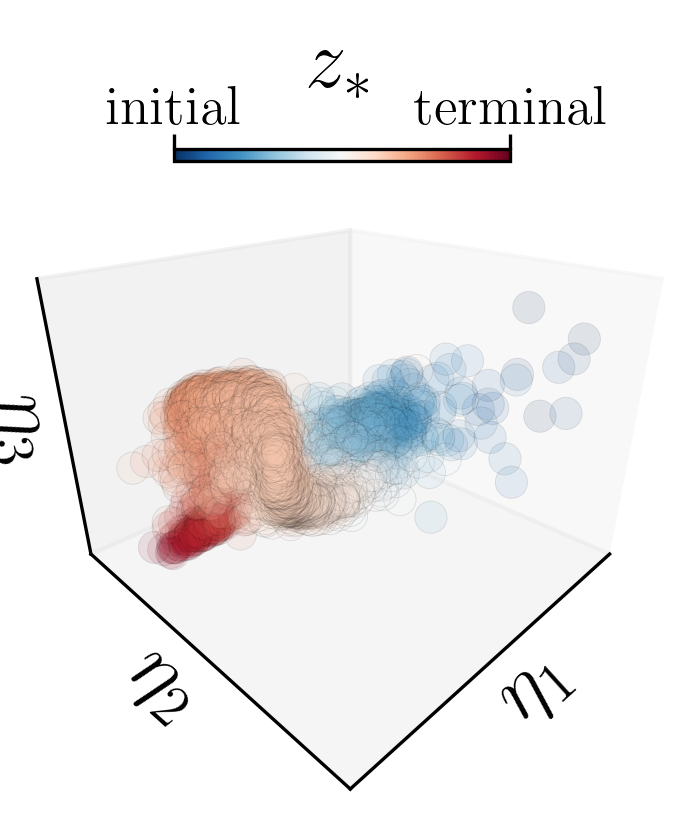

In [143]:
for _, a in enumerate([45, 45+90, 45+2*90]):
    plot2(a, elev)

In this context, one can think of $z_*$ as a continuous pseudolabel that places a given signal along the manifold, somewhere between the initial and terminal states. Can we use this information to reconstruct some actual signals?

## Reconstructing latent dynamics

To reconstruct signals along the trajectory, one approach is to scan the range of $z_*$ learned by the autoencoder and average signals of similar embeddings within relatively small $\delta z_*$ windows.

In [184]:
from scipy.stats import gaussian_kde

n_samples = 11
z_scaled = (z+15)/20
steps = np.linspace(0.2,1, n_samples+1)

samples_AE = np.zeros((n_samples,6000))

for i in range(len(steps)-1):
    idx = np.where((z_scaled>=steps[i]) & (z_scaled<=steps[i+1]))[0]
    kde = gaussian_kde(z_scaled[idx], bw_method=1.5)
    x_kde = np.linspace(steps[i], steps[i + 1], 100)
    y_kde = kde(z_scaled[idx])[:, np.newaxis]
    y_kde /= np.sum(y_kde)
    S_avg = np.sum(X[idx,:]*y_kde, axis=0)
    S_std = np.sum(((X[idx,:] - S_avg)**2)*y_kde, axis=0)
    samples_AE[i,:] = S_avg

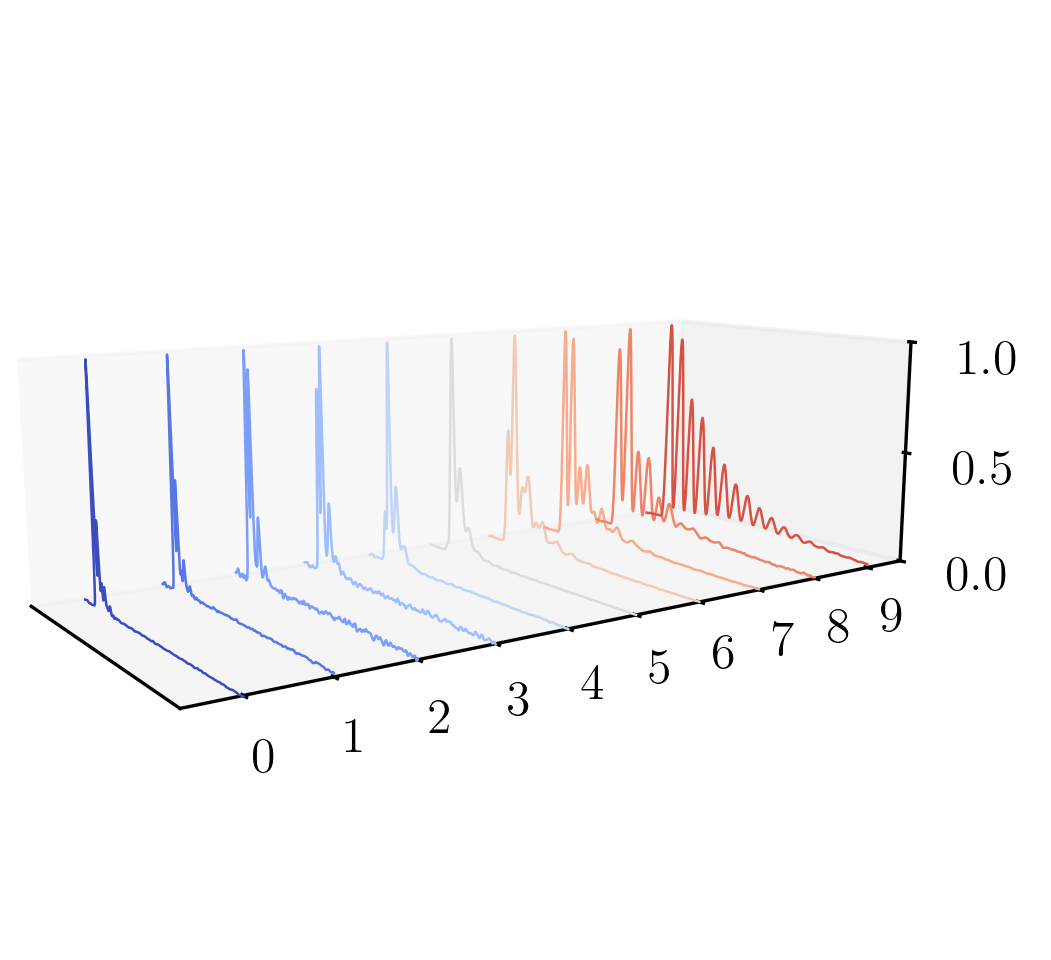

In [197]:
fnt = 12
fig = plt.figure(figsize=(12,3), dpi = 300)
ax = fig.add_subplot(111, projection = '3d')
azim = -35
elev = 10
cMap = plt.get_cmap('coolwarm')

cnt = -1
id_E = np.zeros((11,))
id_T = np.zeros((11,))

for i in range(10):
    cnt += 1
    y = i*np.ones((4000))
    ax.plot(np.arange(4000), y[0:4000], samples_AE[i,:4000]/samples_AE[i,:4000].max(), c = cMap(i/10), linewidth = .6)

#ax.set_ylim((0,9)) # number of sigs
ax.set_xlim((0,4000)) # time
ax.set_zlim((0,1)) # height
ax.set_box_aspect([1.5,3.5,1])

ax.grid(False)
ax.set_yticks((np.linspace(0,9, 10, endpoint=True)))
ax.set_zticks((0,.5,1))
ax.set_xticks([])
ax.azim = azim
ax.elev = elev
ax.set_proj_type('persp', focal_length=.3)
ax.tick_params(labelsize = fnt, direction = 'in')
ax.set_zlabel(r'$\hat{S}^*$', fontsize = fnt, labelpad = 6)

plt.tight_layout()

plt.subplots_adjust(left = 0.1, right = .9, top = .9, bottom = -.1)

plt.show()

As can be seen, we were able to reconstruct a collection of 10 representative signals along the trajectory. These signals span the latent trajectory and allow us to visualize:
* The different types of signatures one can find in the data set.
* Their ordinal ranking with respect to one another, characterized by $z_*$.

## Implications

**In reality, the signals corresponding to the initial (signal 0) and terminal (signal 9) states correspond to the boundary limits of the flame!**\
\
*What does this mean?*\
In the present experiment, both the fuel (hydrogen) and oxidizer (oxygen) stream are separated. We can depict this as:
$$
\begin{align}
H_2 \rightarrow H_2O \leftarrow O_2
\end{align}
$$
Upon close inspection, we realize signal 0 and 9 correspond to measurements taken near the $H_2$ and $O_2$ inlets, respectively!

Similarly, signal 5, which appears in the middle of the trajectory, depicts the burnt gases at equilibrium, rich in $H_2O$!